In [1]:
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import warnings
import pickle
import sys

%matplotlib inline
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import randint
from scipy import stats
from time import time

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

C:\Users\layne\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
with open("final_project_dataset.pkl", "r") as data_file:
    enron_data = pickle.load(data_file)

In [3]:
names = []
zeros = []
pois = []
for person in enron_data:
    zero = 0
    pois.append(enron_data[person]['poi'])
    for key in enron_data[person]:
        value = enron_data[person][key]
        if value == (0 or 'NaN'):
            zero += 1
    names.append(person)
    zeros.append(zero)

(array([  6.,  43.,  16.,  12.,  10.,  24.,   6.,  18.,  10.,   1.]),
 array([  2. ,   3.8,   5.6,   7.4,   9.2,  11. ,  12.8,  14.6,  16.4,
         18.2,  20. ]),
 <a list of 10 Patch objects>)

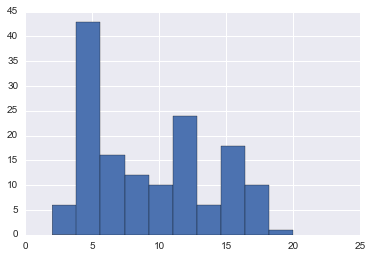

In [31]:
plt.hist(zeros)

In [4]:
poi_true = []
poi_false = []
for i in range(0, len(zeros)):
    if pois[i] == True:
        poi_true.append(zeros[i])
    else:
        poi_false.append(zeros[i])

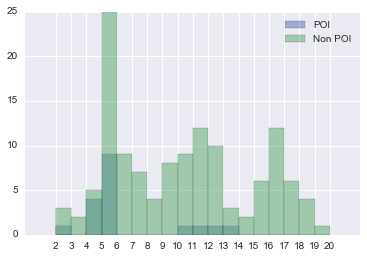

In [5]:
binwidth = 1
bins= range(min(poi_false), max(poi_false) + binwidth, binwidth)

plt.hist(poi_true, bins, alpha=0.5, label='POI')
plt.hist(poi_false, bins, alpha=0.5, label='Non POI')
plt.legend(loc='upper right')
plt.xticks(np.arange(min(poi_false), max(poi_false)+1, 1.0))
plt.xlim(0, 22)
plt.show()

In [ ]:
poi_true

In [6]:
for i in range(0, len(zeros)):
    if zeros[i] > 14:
        enron_data.pop(names[i], 0)
        print names[i]
        
enron_data.pop("TOTAL", 0)

LOWRY CHARLES P
WALTERS GARETH W
CHAN RONNIE
WODRASKA JOHN
URQUHART JOHN A
WHALEY DAVID A
MENDELSOHN JOHN
CLINE KENNETH W
WAKEHAM JOHN
DUNCAN JOHN H
LEMAISTRE CHARLES
WROBEL BRUCE
MEYER JEROME J
SCRIMSHAW MATTHEW
GATHMANN WILLIAM D
GILLIS JOHN
LOCKHART EUGENE E
PEREIRA PAULO V. FERRAZ
BLAKE JR. NORMAN P
GRAY RODNEY
THE TRAVEL AGENCY IN THE PARK
NOLES JAMES L
CHRISTODOULOU DIOMEDES
WINOKUR JR. HERBERT S
BADUM JAMES P
YEAP SOON
FUGH JOHN L
SAVAGE FRANK
GRAMM WENDY L


{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

In [7]:
enron_df = pd.DataFrame.from_dict(enron_data, "index")

financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
                      'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses',
                      'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
removed_financial_features = ['deferral_payments', 'loan_advances', 'restricted_stock_deferred', 'director_fees']

financial_features = [feature for feature in financial_features if feature not in removed_financial_features]
financial_df = enron_df[financial_features]
financial_df = financial_df.replace("NaN", 0)
financial_df["bonus_over_salary"] = financial_df["bonus"] / financial_df["salary"]
financial_df["stock_value_over_salary"] = financial_df["total_stock_value"] / financial_df["salary"]

financial_df = financial_df.drop("exercised_stock_options", 1)

email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 
                  'from_this_person_to_poi', 'shared_receipt_with_poi']

email_df = enron_df[email_features]
email_df = email_df.replace("NaN", 0)
email_df["received_from_poi_over_toal_received"] = email_df["from_poi_to_this_person"] / email_df["to_messages"]
email_df["sent_to_poi_over_toal_sent"] = email_df["from_this_person_to_poi"] / email_df["from_messages"]


features_df = financial_df.join(email_df).join(enron_df["poi"])
features_df["payments_over_sent_poi_ratio"] = financial_df["total_payments"] / email_df["sent_to_poi_over_toal_sent"]
features_df["payments_over_received_poi_ratio"] = financial_df["total_payments"] / email_df["received_from_poi_over_toal_received"]

features_df = features_df.replace(["inf","-inf", "NaN"], 0)
dataset = features_df.to_dict(orient='index')

labels_df = enron_df["poi"]

feature_list = []
feature_list = features_df.columns.tolist()
#move poi to front of list for tester.py
feature_list.insert(0, feature_list.pop(feature_list.index('poi')))


In [8]:
def twoFeatureScatter(data, f1Label, f2Label):
    features = [f1Label, f2Label]
    data = featureFormat(enron_data, features)
    for point in data:
        f1 = point[0]
        f2 = point[1]
        plt.scatter(f1, f2)

    plt.xlabel(f1Label)
    plt.ylabel(f2Label)
    plt.show()

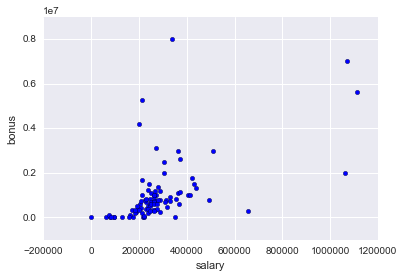

In [10]:
twoFeatureScatter(dataset, 'salary', 'bonus')

PCA before SelectKBest in order to reduce infromation loss. Using Gaussian NB in one test PCA before SKB increased the F1 score from 0.26316 to 0.35967

In [36]:
pipe = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('pca', PCA()),
        ('skb', SelectKBest())
    ])
param = {
        'skb__k':randint(1,9),
        'pca__n_components':randint(8,19)
    }

In [37]:
names = []
pipes = []
params = []

names.append('Gaussian Naive Bayes')
pipes.append(('gnb', GaussianNB()))
params.append({
    })

names.append('Support Vector Machine')
pipes.append(('svc', SVC()))
params.append({
        'svc__kernel':('poly', 'rbf', 'sigmoid'), 
        'svc__C':randint(1,151), 
        'svc__gamma':randint(1,21)
    })

names.append('Decision Tree Classifier')
pipes.append(('dtc', DecisionTreeClassifier()))
params.append({
        'dtc__criterion':('gini', 'entropy'), 
        'dtc__splitter':('best', 'random'),
        'dtc__min_samples_split':randint(2,26),
        'dtc__max_depth':randint(10,51),
        'dtc__max_leaf_nodes':randint(5,31)
    })

names.append('K Neigbors Classifier')
pipes.append(('knc', KNeighborsClassifier()))
params.append({
        'knc__n_neighbors':randint(1, 31), 
        'knc__weights':('uniform', 'distance')
    })

names.append('Random Forest Classifier')
pipes.append(('rfc', RandomForestClassifier()))
params.append({
        'rfc__n_estimators':randint(2,21), 
        'rfc__criterion':('gini','entropy')
    })

names.append('AdaBoost Classifier')
pipes.append(('abc', AdaBoostClassifier()))
params.append({
        'abc__n_estimators':randint(2,11), 
        'abc__learning_rate':randint(1,6)
    })

pipelines = []
parameters = []

for i in range(0, len(pipes)):
    pipelines.append(Pipeline(steps=[x for x in pipe.steps]))
    pipelines[i].steps.append(pipes[i])
    parameters.append(param.copy())
    parameters[i].update(params[i])
    
classifiers = []
classifiers.extend((names, pipelines, parameters))

In [ ]:
#hold
names.append('K Neigbors Classifier (Ball Tree)')
pipes.append(('knc', KNeighborsClassifier()))
params.append({
        'knc__algorithm':['ball_tree'],
        'knc__leaf_size':randint(5,100),
        'knc__p':randint(1,5),
        'knc__n_neighbors':randint(1,26), 
        'knc__weights':('uniform', 'distance')
    })

names.append('K Neigbors Classifier (KD Tree)')
pipes.append(('knc', KNeighborsClassifier()))
params.append({
        'knc__algorithm':['kd_tree'],
        'knc__leaf_size':randint(5,100),
        'knc__p':randint(1,5),
        'knc__n_neighbors':randint(1,26), 
        'knc__weights':('uniform', 'distance')
    })

names.append('K Neigbors Classifier (Brute)')
pipes.append(('knc', KNeighborsClassifier()))
params.append({
        'knc__algorithm':['brute'],
        'knc__p':randint(1,5),
        'knc__n_neighbors':randint(1,26), 
        'knc__weights':('uniform', 'distance')
    })


In [25]:
def search_test_classifier(n_iter, n_splits, folds, clfs, dataset, feature_list):
    
    cv = StratifiedShuffleSplit(n_splits=n_splits, random_state=42, 
                                          test_size=0.3)
    for i in range(0,len(clfs[0])):
        print "\n", clfs[0][i], "------------------------------------------"
        
        start = t0 = time() 
        warnings.filterwarnings('ignore')
        rs = RandomizedSearchCV(clfs[1][i], param_distributions=clfs[2][i],
                                n_iter=n_iter, scoring='f1', cv=cv,
                                random_state=42)
        rs.fit(features_df, labels_df)
        print "\nSearch/Fit Time:", round(time()-t0, 3), "s\n"

        t0 = time() 
        test_classifier(rs.best_estimator_, dataset, feature_list, folds=folds)
        print "Test Time:", round(time()-t0, 3), "s"
    
    print "\nTotal Run Time:", round(time()-start, 3), "s"

In [26]:
def remove_classifier(target, clfs):
    for i in range(0,len(clfs[0])):
        if clfs[0][i] == target:
            clfs[0].remove(clfs[0][i])
            clfs[1].remove(clfs[1][i])
            clfs[2].remove(clfs[2][i])
            break

In [38]:
test_classifier(GaussianNB(), dataset, feature_list)

GaussianNB(priors=None)
	Accuracy: 0.79483	Precision: 0.35324	Recall: 0.27800	F1: 0.31114	F2: 0.29037
	Total predictions: 12000	True positives:  556	False positives: 1018	False negatives: 1444	True negatives: 8982



In [27]:
test_classifier(GaussianNB(), dataset, feature_list)

GaussianNB(priors=None)
	Accuracy: 0.73060	Precision: 0.25802	Recall: 0.18500	F1: 0.21549	F2: 0.19610
	Total predictions: 5000	True positives:  185	False positives:  532	False negatives:  815	True negatives: 3468



Testing Classifiers, first run through

In [14]:
search_test_classifier(25, 50, 1000, classifiers, dataset, feature_list)


Gaussian Naive Bayes ------------------------------------------

Search/Fit Time: 19.223 s

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('skb', SelectKBest(k=2, score_func=<function f_classif at 0x000000000AB30898>)), ('gnb', GaussianNB(priors=None))])
	Accuracy: 0.79983	Precision: 0.34173	Recall: 0.21700	F1: 0.26544	F2: 0.23409
	Total predictions: 12000	True positives:  434	False positives:  836	False negatives: 1566	True negatives: 9164

Test Time: 2.018 s

Support Vector Machine ------------------------------------------

Search/Fit Time: 33.137 s

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('skb', SelectKBest(k=7, score_func=<function f_classif at 0x000000000AB30898>)

In [28]:
search_test_classifier(50, 50, 1000, classifiers, dataset, feature_list)


Gaussian Naive Bayes ------------------------------------------

Search/Fit Time: 18.646 s

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=17, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('skb', SelectKBest(k=3, score_func=<function f_classif at 0x000000000AB30898>)), ('gnb', GaussianNB(priors=None))])
	Accuracy: 0.71800	Precision: 0.15254	Recall: 0.09000	F1: 0.11321	F2: 0.09804
	Total predictions: 5000	True positives:   90	False positives:  500	False negatives:  910	True negatives: 3500

Test Time: 1.876 s

Support Vector Machine ------------------------------------------

Search/Fit Time: 24.477 s

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('skb', SelectKBest(k=7, score_func=<function f_classif at 0x000000000AB30898>))

In [ ]:
remove_classifier("Gaussian Naive Bayes", classifiers)

In [ ]:
remove_classifier("Support Vector Machine", classifiers)

In [ ]:
remove_classifier("Decision Tree Classifier", classifiers)

In [ ]:
#remove_classifier("K Neigbors Classifier", classifiers)

In [ ]:
remove_classifier("Random Forest Classifier", classifiers)

In [ ]:
remove_classifier("AdaBoost Classifier", classifiers)

In [ ]:
names = []
pipes = []
params = []

names.append('K Neigbors Classifier (Ball Tree)')
pipes.append(('knc', KNeighborsClassifier()))
params.append({
        'knc__algorithm':['ball_tree'],
        'knc__leaf_size':randint(5,100),
        'knc__p':randint(1,5),
        'knc__n_neighbors':randint(1,26), 
        'knc__weights':('uniform', 'distance')
    })

names.append('K Neigbors Classifier (KD Tree)')
pipes.append(('knc', KNeighborsClassifier()))
params.append({
        'knc__algorithm':['kd_tree'],
        'knc__leaf_size':randint(5,100),
        'knc__p':randint(1,5),
        'knc__n_neighbors':randint(1,26), 
        'knc__weights':('uniform', 'distance')
    })

names.append('K Neigbors Classifier (Brute)')
pipes.append(('knc', KNeighborsClassifier()))
params.append({
        'knc__algorithm':['brute'],
        'knc__p':randint(1,5),
        'knc__n_neighbors':randint(1,26), 
        'knc__weights':('uniform', 'distance')
    })

pipelines = []
parameters = []

for i in range(0, len(pipes)):
    pipelines.append(Pipeline(steps=[x for x in pipe.steps]))
    pipelines[i].steps.append(pipes[i])
    parameters.append(param.copy())
    parameters[i].update(params[i])
    
classifiers = []
classifiers.extend((names, pipelines, parameters))

In [ ]:
search_test_classifier(150, 50, 1000, classifiers, dataset, feature_list)

Random Forest takes far too long to run and test so we will remove it and increase the number of iterations and folds and re-test the classifiers

In [ ]:
remove_classifier("Random Forest Classifier", classifiers)

In [ ]:
search_test_classifier(50, 100, 1000, classifiers, dataset, feature_list)

The results from the second itteration were that 3 of the 5 remaining classifiers (Gaussian Naive Bayes, Support Vector Machine, and AdaBoost) had F1 scores above 0.3. While SVM and AdaBoost did not pass on both recall and precision, we will try to run more iteration of the random search on these classifiers and see if there is any adjustments on parameters that we can make.

In [ ]:
remove_classifier("Decision Tree Classifier", classifiers)
remove_classifier("K Neigbors Classifier", classifiers)

In [ ]:
search_test_classifier(200, 200, 1000, classifiers, dataset, feature_list)

In [ ]:
search_test_classifier(200, 500, 1000, classifiers, dataset, feature_list)

After testing the remaining classifiers with a higher number of parameter iterations and validation folds it can be seen that the Gaussian Naive Bayes classifier remains the classifer with the highest F1 score while having both percision and recall above 0.3. This being said, there could be better classifier/parameter combinations available that we not observed in this code due to the random search and/or the ranges for the random searches that were set in the parameter initalizations. 

In [ ]:
pipe = Pipeline(steps=[
        ('scaler', MinMaxScaler()),
        ('pca', PCA()),
        ('skb', SelectKBest()),
        ('gnb', GaussianNB())
    ])
param = [{'skb__k':range(1,9),'pca__n_components':range(8,19)},
         {'skb__k':range(1,8),'pca__n_components':[7]},
         {'skb__k':range(1,7),'pca__n_components':[6]},
         {'skb__k':range(1,6),'pca__n_components':[5]},
         {'skb__k':range(1,5),'pca__n_components':[4]},
         {'skb__k':range(1,4),'pca__n_components':[3]},
         {'skb__k':range(1,3),'pca__n_components':[2]}]       

In [ ]:
cv = StratifiedShuffleSplit(n_splits=100, random_state=42, test_size=0.3)
gs = GridSearchCV(pipe, param, scoring='f1', cv=cv)
gs.fit(features_df, labels_df)
clf = gs.best_estimator_
gs.best_params_

In [ ]:
test_classifier(clf, dataset, feature_list)

"THE TRAVEL AGENCY IN THE PARK" 
parameters = {'tree__criterion': ('gini','entropy'),
              'tree__splitter':('best','random'),
              'tree__min_samples_split':[2, 10, 20],
                'tree__max_depth':[10,15,20,25,30],
                'tree__max_leaf_nodes':[5,10,30]}

In [ ]:
KNeighborsClassifier 